# 1.Setting Environment

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# Colab 환경 설정
# requirements : https://github.com/SKTBrain/KoBERT/blob/master/kobert_hf/requirements.txt
!pip install gluonnlp pandas tqdm
!pip install mxnet
!pip install sentencepiece
!pip install transformers
!pip install torch

In [3]:
# https://github.com/SKTBrain/KoBERT/tree/master/kobert_hf 의 kobert_tokenizer 폴더를 다운받는 코드
!pip install 'git+https://github.com/SKTBrain/KoBERT.git#egg=kobert_tokenizer&subdirectory=kobert_hf'

  Cloning https://github.com/SKTBrain/KoBERT.git to /tmp/pip-install-e2tnbmkz/kobert-tokenizer_8a9d0335b4024316801dcb92e24e0559
  Running command git clone --filter=blob:none --quiet https://github.com/SKTBrain/KoBERT.git /tmp/pip-install-e2tnbmkz/kobert-tokenizer_8a9d0335b4024316801dcb92e24e0559
  Resolved https://github.com/SKTBrain/KoBERT.git to commit 47a69af87928fc24e20f571fe10c3cc9dd9af9a3
  Preparing metadata (setup.py) ... done


In [4]:
# https://github.com/SKTBrain/KoBERT 의 파일들을 다운받는 코드
#!pip install git+https://git@github.com/SKTBrain/KoBERT.git@master

In [5]:
# KoBERT
from kobert_tokenizer import KoBERTTokenizer
from transformers import BertModel

from transformers import AdamW
from transformers.optimization import get_cosine_schedule_with_warmup

In [6]:
# Setting Library
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import gluonnlp as nlp
import numpy as np
from tqdm import tqdm, tqdm_notebook
import pandas as pd

In [7]:
# GPU 사용
device = torch.device("cuda:0")

# CPU 사용 시
# device = torch.device("cpu")

In [8]:
tokenizer = KoBERTTokenizer.from_pretrained('skt/kobert-base-v1')
bertmodel = BertModel.from_pretrained('skt/kobert-base-v1', return_dict=False)
vocab = nlp.vocab.BERTVocab.from_sentencepiece(tokenizer.vocab_file, padding_token='[PAD]')

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'XLNetTokenizer'. 
The class this function is called from is 'KoBERTTokenizer'.


In [9]:
# [AI Hub] 감정 분류를 위한 대화 음성 데이터셋 불러오기
data = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/5차년도_2차.csv", encoding='cp949')

---

# 2.데이터 전처리

In [10]:
data.head()

,wav_id,발화문,상황,1번 감정,1번 감정세기,2번 감정,2번 감정세기,3번 감정,3번 감정세기,4번 감정,4번감정세기,5번 감정,5번 감정세기,나이,성별
0,5f4141e29dd513131eacee2f,헐! 나 이벤트에 당첨 됐어.,happiness,angry,2,surprise,2,happiness,2,happiness,2,happiness,2,48,female
1,5f4141f59dd513131eacee30,내가 좋아하는 인플루언서가 이벤트를 하더라고. 그래서 그냥 신청 한번 해봤지.,happiness,neutral,0,happiness,2,happiness,2,happiness,2,happiness,2,48,female
2,5f4142119dd513131eacee31,"한 명 뽑는 거였는데, 그게 바로 내가 된 거야.",happiness,angry,2,happiness,2,happiness,2,happiness,2,happiness,2,48,female
3,5f4142279dd513131eacee32,"당연히 마음에 드는 선물이니깐, 이벤트에 내가 신청 한번 해본 거지. 비싼 거야. ...",happiness,angry,2,happiness,2,happiness,2,happiness,2,happiness,1,48,female
4,5f3c9ed98a3c1005aa97c4bd,에피타이저 정말 좋아해. 그 것도 괜찮은 생각인 것 같애.,neutral,happiness,2,happiness,1,happiness,2,happiness,1,happiness,1,48,female


In [11]:
data.shape

(19374, 15)

In [12]:
data['상황'].unique()

array(['happiness', 'neutral', 'sadness', 'angry', 'surprise', 'disgust',
       'fear'], dtype=object)

In [13]:
# 7개의 감정 class → 숫자
data.loc[(data['상황'] == "fear"), '상황'] = 0  # fear → 0
data.loc[(data['상황'] == "surprise"), '상황'] = 1  # surprise → 1
data.loc[(data['상황'] == "angry"), '상황'] = 2  # angry → 2
data.loc[(data['상황'] == "sadness"), '상황'] = 3  # sadness → 3
data.loc[(data['상황'] == "neutral"), '상황'] = 4  # neutral → 4
data.loc[(data['상황'] == "happiness"), '상황'] = 5  # happiness → 5
data.loc[(data['상황'] == "disgust"), '상황'] = 6  # disgust → 6

In [14]:
data['상황'].unique()

array([5, 4, 3, 2, 1, 6, 0], dtype=object)

In [15]:
# [발화문, 상황] data_list 생성
data_list = []
for ques, label in zip (data['발화문'], data['상황']):
  data = []
  data.append(ques)
  data.append(str(label))

  data_list.append(data)

In [16]:
print(data)
print(data_list[:10])

['걱정해줘서 고마워.', '6']
[['헐! 나 이벤트에 당첨 됐어.', '5'], ['내가 좋아하는 인플루언서가 이벤트를 하더라고. 그래서 그냥 신청 한번 해봤지.', '5'], ['한 명 뽑는 거였는데, 그게 바로 내가 된 거야.', '5'], ['당연히 마음에 드는 선물이니깐, 이벤트에 내가 신청 한번 해본 거지. 비싼 거야. 그래서 못 산 향수야.', '5'], ['에피타이저 정말 좋아해. 그 것도 괜찮은 생각인 것 같애.', '4'], ['난 부페 형식의 음식들도 정말 좋아해. 그 것도 좀 알려 줘.', '4'], ['응. 완전히 끝난 거야. 한 달 동안 주말에 쉬지도 못하고 일만 했거든.', '5'], ['신나는 음악 듣는 것도 좋고, 어디 여행 가고 싶고 이 것 저 것 다 해보고 싶어.', '5'], ['친구들도 내 연락 기다리고 있을 텐데 내가 까먹고 있었네?', '5'], ['그래. 일단은 친구들부터 만나서 여행 계획에 대해서 얘기 좀 해봐야 되겠어.', '5']]


---

## 2-1.Split train & test data set

In [17]:
from sklearn.model_selection import train_test_split

In [18]:
dataset_train, dataset_test = train_test_split(data_list, test_size = 0.2, shuffle = True, random_state = 32)

In [19]:
print(len(dataset_train), len(dataset_test))

15499 3875


---

## 2-2.입력 데이터셋 토큰화

In [20]:
#tokenizer = get_tokenizer()
tok = tokenizer.tokenize

In [21]:
# BERTDataset : 각 데이터가 BERT 모델의 입력으로 들어갈 수 있도록 tokenization, int encoding, padding하는 함수
# 출처 : https://github.com/SKTBrain/KoBERT/blob/master/scripts/NSMC/naver_review_classifications_pytorch_kobert.ipynb

class BERTDataset(Dataset):
    def __init__(self, dataset, sent_idx, label_idx, bert_tokenizer, vocab, max_len,
                 pad, pair):
        transform = nlp.data.BERTSentenceTransform(
            bert_tokenizer, max_seq_length=max_len, vocab=vocab, pad=pad, pair=pair)

        self.sentences = [transform([i[sent_idx]]) for i in dataset]
        self.labels = [np.int32(i[label_idx]) for i in dataset]

    def __getitem__(self, i):
        return (self.sentences[i] + (self.labels[i], ))

    def __len__(self):
        return (len(self.labels))


---

## 2-3.Setting parameters

In [22]:
# parameter 값 출처 : https://github.com/SKTBrain/KoBERT/blob/master/scripts/NSMC/naver_review_classifications_pytorch_kobert.ipynb
max_len = 64
batch_size = 64
warmup_ratio = 0.1
num_epochs = 5
max_grad_norm = 1
log_interval = 200
learning_rate =  5e-5

---

## 2-4.tokenization, int encoding, padding

In [23]:
# BERTDataset : 각 데이터가 BERT 모델의 입력으로 들어갈 수 있도록 tokenization, int encoding, padding하는 함수
data_train = BERTDataset(dataset_train, 0, 1, tok, vocab, max_len, True, False)
data_test = BERTDataset(dataset_test, 0, 1, tok, vocab, max_len, True, False)

In [24]:
# torch 형식의 dataset을 만들어주면서, 입력 데이터셋의 전처리
train_dataloader = torch.utils.data.DataLoader(data_train, batch_size = batch_size, num_workers = 5)
test_dataloader = torch.utils.data.DataLoader(data_test, batch_size = batch_size, num_workers = 5)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


---

# 3.KoBERT 모델 구현

In [25]:
# KoBERT 오픈소스 내 예제코드 : https://github.com/SKTBrain/KoBERT/blob/master/scripts/NSMC/naver_review_classifications_pytorch_kobert.ipynb
class BERTClassifier(nn.Module):
    def __init__(self,
                 bert,
                 hidden_size = 768,
                 num_classes = 7,   # 클래스 수 조정
                 dr_rate = None,
                 params = None):
        super(BERTClassifier, self).__init__()
        self.bert = bert
        self.dr_rate = dr_rate

        self.classifier = nn.Linear(hidden_size , num_classes)
        if dr_rate:
            self.dropout = nn.Dropout(p = dr_rate)

    def gen_attention_mask(self, token_ids, valid_length):
        attention_mask = torch.zeros_like(token_ids)
        for i, v in enumerate(valid_length):
            attention_mask[i][:v] = 1
        return attention_mask.float()

    def forward(self, token_ids, valid_length, segment_ids):
        attention_mask = self.gen_attention_mask(token_ids, valid_length)

        _, pooler = self.bert(input_ids = token_ids, token_type_ids = segment_ids.long(), attention_mask = attention_mask.float().to(token_ids.device),return_dict = False)
        if self.dr_rate:
            out = self.dropout(pooler)
        return self.classifier(out)

In [26]:
# BERT  모델 불러오기
model = BERTClassifier(bertmodel,  dr_rate = 0.5).to(device)

In [27]:
# optimizer와 schedule 설정
# Prepare optimizer and schedule (linear warmup and decay)
no_decay = ['bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
    {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
]

optimizer = AdamW(optimizer_grouped_parameters, lr = learning_rate)
loss_fn = nn.CrossEntropyLoss() # 다중분류를 위한 loss function

t_total = len(train_dataloader) * num_epochs
warmup_step = int(t_total * warmup_ratio)

scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps = warmup_step, num_training_steps = t_total)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [28]:
# calc_accuracy : 정확도 측정을 위한 함수
def calc_accuracy(X,Y):
    max_vals, max_indices = torch.max(X, 1)
    train_acc = (max_indices == Y).sum().data.cpu().numpy()/max_indices.size()[0]
    return train_acc

train_dataloader

---

# 4.학습한 모델 불러오기

In [29]:
model = BERTClassifier(bertmodel,  dr_rate = 0.5).to(device)
model.load_state_dict(torch.load('/content/drive/MyDrive/myModel/model.pth'))
model.to(device)

BERTClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(8002, 768, padding_idx=1)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_aff

> epoch 5 train acc 0.9776877572016461

> epoch 5 test acc 0.9208138173302107

---

# 5.Test

In [30]:
# predict : 학습 모델을 활용하여 다중 분류된 클래스를 출력해주는 함수
# 코드 출처 : https://hoit1302.tistory.com/159

def predict(predict_sentence): # input = 감정분류하고자 하는 sentence

    data = [predict_sentence, '0']
    dataset_another = [data]

    another_test = BERTDataset(dataset_another, 0, 1, tok, vocab, max_len, True, False) # 토큰화한 문장
    test_dataloader = torch.utils.data.DataLoader(another_test, batch_size = batch_size, num_workers = 5) # torch 형식 변환

    model.eval()

    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(test_dataloader):
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)

        valid_length = valid_length
        label = label.long().to(device)

        out = model(token_ids, valid_length, segment_ids)


        test_eval = []
        for i in out: # out = model(token_ids, valid_length, segment_ids)
            logits = i
            logits = logits.detach().cpu().numpy()

            if np.argmax(logits) == 0:
                test_eval.append("공포가")
            elif np.argmax(logits) == 1:
                test_eval.append("놀람이")
            elif np.argmax(logits) == 2:
                test_eval.append("분노가")
            elif np.argmax(logits) == 3:
                test_eval.append("슬픔이")
            elif np.argmax(logits) == 4:
                test_eval.append("중립이")
            elif np.argmax(logits) == 5:
                test_eval.append("행복이")
            elif np.argmax(logits) == 6:
                test_eval.append("혐오가")

        print(">> 입력하신 내용에서 " + test_eval[0] + " 느껴집니다.")

# csv파일 읽기



In [31]:
import pandas as pd
import matplotlib.pyplot as plt


In [32]:
df = pd.read_csv('/content/drive/MyDrive/myComment/Test_0720_0725.csv')

In [33]:
def predict(comment):
    data = [comment, '0']
    dataset_another = [data]

    another_test = BERTDataset(dataset_another, 0, 1, tok, vocab, max_len, True, False)
    test_dataloader = torch.utils.data.DataLoader(another_test, batch_size=1, num_workers=5)

    model.eval()

    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(test_dataloader):
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length = valid_length
        label = label.long().to(device)

        out = model(token_ids, valid_length, segment_ids)

        for i in out:
            logits = i
            logits = logits.detach().cpu().numpy()
            predicted_label = np.argmax(logits)

            if predicted_label == 0:
                return "공포"
            elif predicted_label == 1:
                return "놀람"
            elif predicted_label == 2:
                return "분노"
            elif predicted_label == 3:
                return "슬픔"
            elif predicted_label == 4:
                return "중립"
            elif predicted_label == 5:
                return "행복"
            elif predicted_label == 6:
                return "혐오"


In [1]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
fonts-nanum is already the newest version (20200506-1).
0 upgraded, 0 newly installed, 0 to remove and 15 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 12 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/usr/share/fonts/truetype: skipping, looped directory detected
/usr/share/fonts/truetype/humor-sans: skipping, looped directory detected
/usr/share/fonts/truetype/liberation: skipping, looped directory detected
/usr/share/fonts/truetype/

In [34]:
import matplotlib.pyplot as plt

plt.rc('font', family='NanumBarunGothic')
labels = '공포', '놀람', '분노', '슬픔', '중립', '행복', '혐오'

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


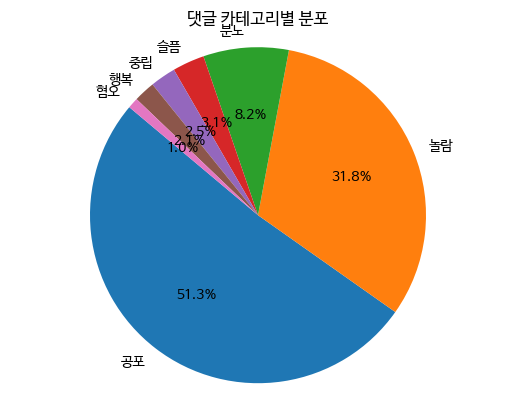

In [ ]:
df['Label'] = df['댓글내용'].apply(predict)

# 각 라벨의 발생 횟수 계산
label_counts = df['Label'].value_counts()

# 원 그래프 그리기
plt.pie(label_counts, labels=labels, autopct='%1.1f%%', startangle=140)
plt.title('댓글 카테고리별 분포')
plt.axis('equal')  # 동일한 비율로 그리기 위해 설정
plt.show()

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


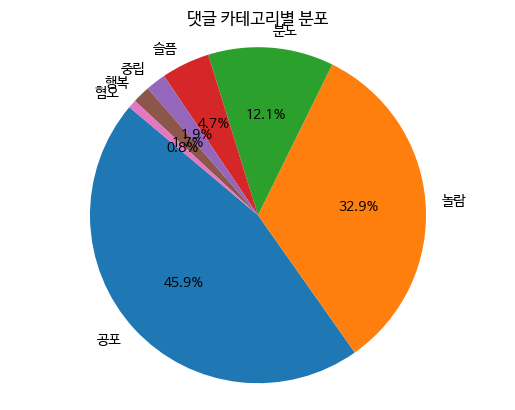

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/myComment/Test_0726_0731.csv')
# 각 댓글에 대해 예측 함수 적용

df['Label'] = df['댓글내용'].apply(predict)

# 각 라벨의 발생 횟수 계산
label_counts = df['Label'].value_counts()

# 원 그래프 그리기
plt.pie(label_counts, labels=labels, autopct='%1.1f%%', startangle=140)
plt.title('댓글 카테고리별 분포')
plt.axis('equal')  # 동일한 비율로 그리기 위해 설정
plt.show()

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


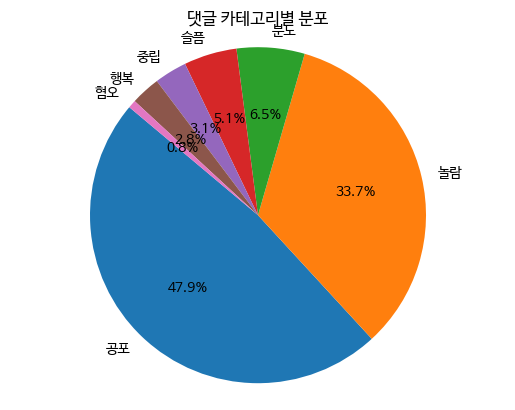

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/myComment/Test_0801_0806.csv')
# 각 댓글에 대해 예측 함수 적용

df['Label'] = df['댓글내용'].apply(predict)

# 각 라벨의 발생 횟수 계산
label_counts = df['Label'].value_counts()

# 원 그래프 그리기
plt.pie(label_counts, labels=labels, autopct='%1.1f%%', startangle=140)
plt.title('댓글 카테고리별 분포')
plt.axis('equal')  # 동일한 비율로 그리기 위해 설정
plt.show()

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


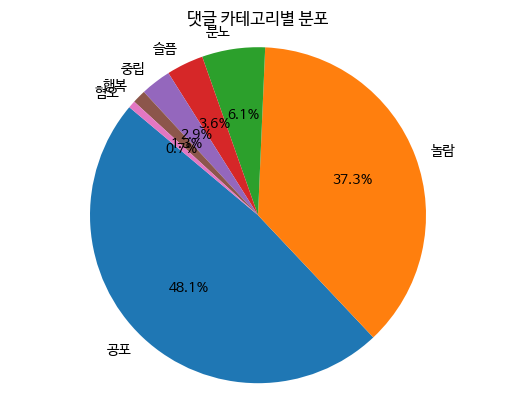

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/myComment/Test_0807_0812.csv')
# 각 댓글에 대해 예측 함수 적용

df['Label'] = df['댓글내용'].apply(predict)

# 각 라벨의 발생 횟수 계산
label_counts = df['Label'].value_counts()

# 원 그래프 그리기
plt.pie(label_counts, labels=labels, autopct='%1.1f%%', startangle=140)
plt.title('댓글 카테고리별 분포')
plt.axis('equal')  # 동일한 비율로 그리기 위해 설정
plt.show()

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


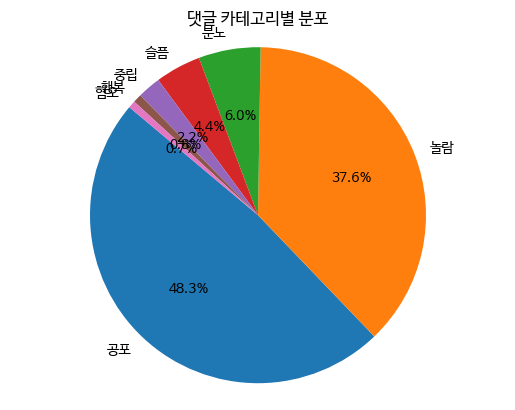

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/myComment/Test_0813_0818.csv')
# 각 댓글에 대해 예측 함수 적용

df['Label'] = df['댓글내용'].apply(predict)

# 각 라벨의 발생 횟수 계산
label_counts = df['Label'].value_counts()

# 원 그래프 그리기
plt.pie(label_counts, labels=labels, autopct='%1.1f%%', startangle=140)
plt.title('댓글 카테고리별 분포')
plt.axis('equal')  # 동일한 비율로 그리기 위해 설정
plt.show()

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


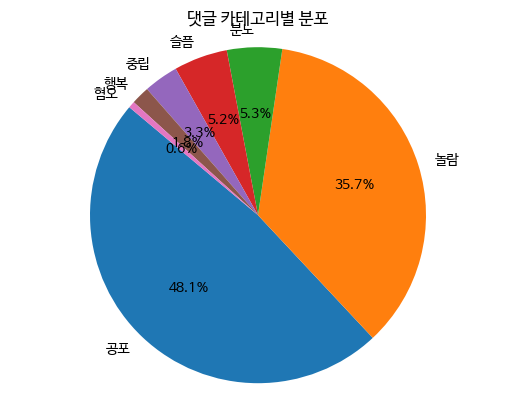

In [35]:
df = pd.read_csv('/content/drive/MyDrive/myComment/Test_0819_0824.csv')
# 각 댓글에 대해 예측 함수 적용

df['Label'] = df['댓글내용'].apply(predict)

# 각 라벨의 발생 횟수 계산
label_counts = df['Label'].value_counts()

# 원 그래프 그리기
plt.pie(label_counts, labels=labels, autopct='%1.1f%%', startangle=140)
plt.title('댓글 카테고리별 분포')
plt.axis('equal')  # 동일한 비율로 그리기 위해 설정
plt.show()

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


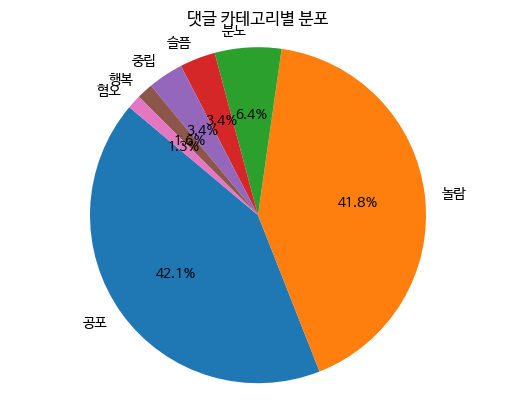

In [36]:
df = pd.read_csv('/content/drive/MyDrive/myComment/Test_0824_0829.csv')
# 각 댓글에 대해 예측 함수 적용

df['Label'] = df['댓글내용'].apply(predict)

# 각 라벨의 발생 횟수 계산
label_counts = df['Label'].value_counts()

# 원 그래프 그리기
plt.pie(label_counts, labels=labels, autopct='%1.1f%%', startangle=140)
plt.title('댓글 카테고리별 분포')
plt.axis('equal')  # 동일한 비율로 그리기 위해 설정
plt.show()